## Aula 6 - Case : Fake News

https://www.kaggle.com/competitions/fake-news/data

##### Faça um modelo de ML com todos os atributos aprendidos
##### Preprocessamento de texto, dataviz (nuvem de palavras ou frequência de palavras - gráfico tipo '1/x') e modelo

In [21]:
import pandas as pd
import numpy as np

Labels

- 1 : Unreliable
- 0 : Reliable

In [73]:
fk_train = pd.read_csv("../../fakenews/train.csv", index_col = "id")
fk_train.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### Análise preliminar dos dados

In [74]:
# Exemplo de texto
fk_train.iloc[0][2]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [75]:
fk_train.shape

(20800, 4)

In [76]:
# Balanceado
fk_train["label"].value_counts(normalize = True)

1    0.500625
0    0.499375
Name: label, dtype: float64

In [78]:
# Analisar quais colunas são NaNs
fk_train.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [79]:
# Ter autores anônimos significa cerca de 98.67% de ser fake news - nesse caso, podemos substituir o NaN por 'Anonymous' para incluir no modelo
fk_train[fk_train["author"].isna()]["label"].value_counts(normalize = True)

1    0.986714
0    0.013286
Name: label, dtype: float64

In [80]:
# Podemos dropar as observações com a coluna 'text' vazia, já que não tem texto para analisar e é 100% fake news
fk_train[fk_train["text"].isna()]["label"].value_counts(normalize = True)

1    1.0
Name: label, dtype: float64

In [81]:
# Podemos dropar as observações com a coluna 'title' vazia, já que não tem texto para analisar e é 100% fake news
fk_train[fk_train["title"].isna()]["label"].value_counts(normalize = True)

1    1.0
Name: label, dtype: float64

In [82]:
# Substituindo valores vazios por 'anonymous' e dropando os outros NaNs
fk_train["author"].fillna("anonymous", inplace = True)
fk_train.dropna(inplace = True)

In [83]:
# Sem NaNs
fk_train.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

#### Pré-processamento

In [84]:
# Preprocessamento

# Bibliotecas
from nltk.tokenize import word_tokenize  # tokenização
from nltk.stem import *  # importar PorterStemmer() e WordNetLemmatizer()
from nltk.corpus import stopwords  # Stopwords
import nltk  # para baixar os 'stopwords' e 'punkt' (punctuation)
import re  # regex

nltk.download('stopwords')
nltk.download('punkt')
# Define as stopwords em inglês
sw_english = set(stopwords.words('english'))

# Instancia o PorterStemmer e WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Função de preprocessamento - 
def preprocessing(string, method = 'stem'):
    """
    Preprocessing for english'
    """
    # Manter somente caracteres e números - sem caracteres especiais
    string = re.sub(r"[^a-zA-Z0-9]+", " ", string)
    # Letras minúsculas
    string = string.lower()
    # tokenização
    words = word_tokenize(string)
    
    filter_words = [word for word in words if word not in sw_english]
    words = []
    
    if method == 'stem':
        for word in filter_words:
            sw = stemmer.stem(word)
            words.append(sw)
        return words
    if method == 'lemma':
        for word in filter_words:
            sw = lemmatizer.lemmatize(word)
            words.append(sw)
        return words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
# Testando somente com os títulos
fk_train['filtered_titles'] = fk_train["title"].apply(lambda x: preprocessing(x, "lemma"))
fk_train['join_words'] = fk_train['filtered_titles'].apply(lambda x: ' '.join(x))

In [87]:
fk_train.head()

,title,author,text,label,filtered_titles,join_words
id,,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[house, dem, aide, even, see, comey, letter, j...",house dem aide even see comey letter jason cha...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"[flynn, hillary, clinton, big, woman, campus, ...",flynn hillary clinton big woman campus breitbart
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"[truth, might, get, fired]",truth might get fired
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,"[15, civilian, killed, single, u, airstrike, i...",15 civilian killed single u airstrike identified
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,"[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


#### Dataviz

In [63]:
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.probability import FreqDist
import nltk
from nltk.corpus import stopwords

stopwords_list = stopwords.words("english")
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
# Concatenar
a = fk_train.iloc[0]["join_words"].split()
b = fk_train.iloc[1]["join_words"].split()

print(a)
print(b)
c = a+b
print(c)

['house', 'dem', 'aide', 'even', 'see', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted']
['flynn', 'hillary', 'clinton', 'big', 'woman', 'campus', 'breitbart']
['house', 'dem', 'aide', 'even', 'see', 'comey', 'letter', 'jason', 'chaffetz', 'tweeted', 'flynn', 'hillary', 'clinton', 'big', 'woman', 'campus', 'breitbart']


In [120]:
fdist = FreqDist(c)
fdist.most_common(10)

[('house', 1),
 ('dem', 1),
 ('aide', 1),
 ('even', 1),
 ('see', 1),
 ('comey', 1),
 ('letter', 1),
 ('jason', 1),
 ('chaffetz', 1),
 ('tweeted', 1)]

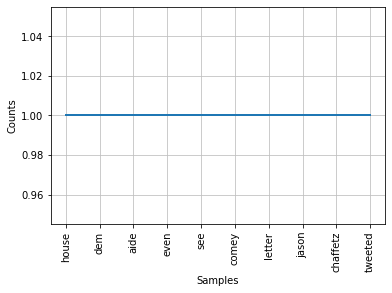

In [121]:
fdist = FreqDist(c)
fdist.plot(10)
plt.show()

In [ ]:
# concatenar as palavras de 'join_words'

for i in range(fk_train.shape[0]):
    fk_train.iloc[0]["join_words"].split()
    words

fk_train.iloc[0]["join_words"].split()

words = []
for i in range(fk_train.shape[0]):
    for title in fk_train.iloc[i]["join_words"]:

## Modelos de ML

In [88]:
# train test split
from sklearn.model_selection import train_test_split

X = fk_train["join_words"]
y = fk_train["label"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [91]:
# Bibliotecas e modelos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Usar os modelos abaixo
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

#### Baseline com Logistic Regression

In [93]:
text_model_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", LogisticRegression())
])

text_model_lr

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', LogisticRegression())])

In [94]:
text_model_lr.fit(X_train, y_train)
predictions = text_model_lr.predict(X_test)

In [99]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))
print()
print(f"A acurácia é {accuracy_score(y_test, predictions)}")

[[2251  341]
 [  49 2410]]

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2592
           1       0.88      0.98      0.93      2459

    accuracy                           0.92      5051
   macro avg       0.93      0.92      0.92      5051
weighted avg       0.93      0.92      0.92      5051


A acurácia é 0.9227875668184518


In [101]:
# Predict proba para curva ROC
y_prob_lr = text_model_lr.predict_proba(X_test)
# Slice do predict proba
y_prob_lr = y_prob_lr[:, 1]

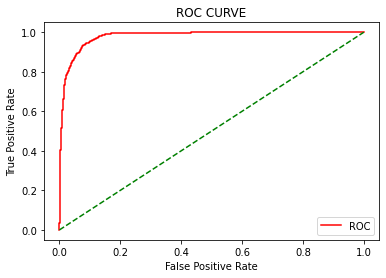

In [103]:
# ROC-AUC 
fp, tp, thresholds = roc_curve(y_test, y_prob_lr)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()